In [1]:
#neural style transfer
#The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are ,  Lcontent , and one that describes the difference between two images in terms of their style,  Lstyle
#then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image),

In [2]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [5]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg',cache_dir='E:\\Tensorflow\\tensorflow\\Tensorflow_packt_exercises\\data')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',cache_dir='E:\\Tensorflow\\tensorflow\\Tensorflow_packt_exercises\\data')

In [6]:
style_path

'E:\\Tensorflow\\tensorflow\\Tensorflow_packt_exercises\\data\\datasets\\kandinsky5.jpg'

In [7]:
# function to load an image and limit its max dimention to 512
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32)

    shape = tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim

    new_shape = tf.cast(shape*scale,tf.int32)

    img = tf.image.resize(img,new_shape)
    img = img[tf.newaxis,:]
    return img

In [8]:
#Function to display an image
def imshow(image,title=None):
    if len(image.shape)>3:
        image = tf.squeeze(image,axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

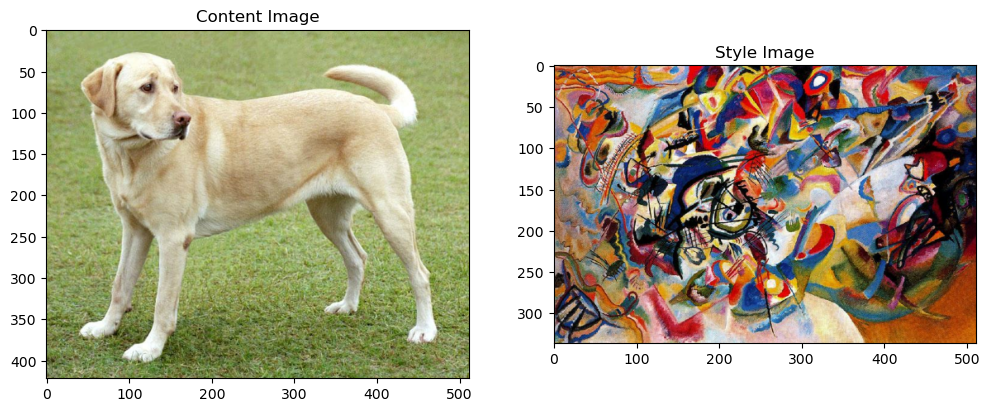

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image,'Content Image')

plt.subplot(1,2,2)
imshow(style_image,'Style Image')


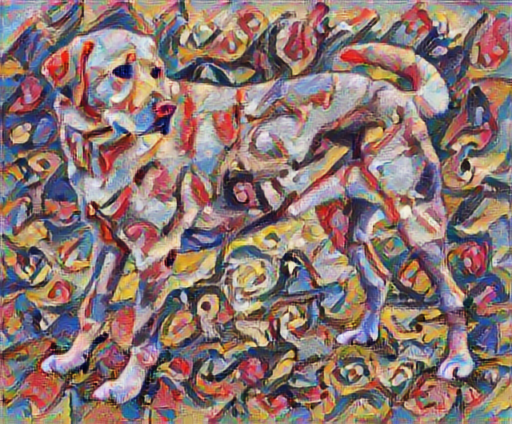

In [10]:
# we can utilize TF-Hub models too to achieve the desired results
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image),tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [11]:
#Load a VGG19 and testrun it to ensure its used correctly
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x,(224,224))
vgg = tf.keras.applications.VGG19(include_top=True,weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [12]:
predict_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name,prob) for (number,class_name,prob) in predict_top_5]

[('Labrador_retriever', 0.49302754),
 ('golden_retriever', 0.23677431),
 ('kuvasz', 0.036340483),
 ('Chesapeake_Bay_retriever', 0.024164664),
 ('Greater_Swiss_Mountain_dog', 0.01864279)]

In [13]:
#vgg without classification head
vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
# choose randon intermediate layers to represent style and content of the image

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

style_extractor = vgg_layers(style_layers)
style_outputs=style_extractor(style_image*255)

for name,output in zip(style_layers,style_outputs):
    print(name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())

block1_conv1
 shape:  (1, 336, 512, 64)
 min:  0.0
 max:  835.5255
 mean:  33.97525
block2_conv1
 shape:  (1, 168, 256, 128)
 min:  0.0
 max:  4625.8564
 mean:  199.82214
block3_conv1
 shape:  (1, 84, 128, 256)
 min:  0.0
 max:  8790.345
 mean:  230.7696
block4_conv1
 shape:  (1, 42, 64, 512)
 min:  0.0
 max:  21565.6
 mean:  791.19775
block5_conv1
 shape:  (1, 21, 32, 512)
 min:  0.0
 max:  3188.9138
 mean:  59.175602


In [22]:
def gram_matrix(input_tensor):
    #Tensor contraction over specified indices and outer product.
    result = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return result/num_locations


In [23]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self,style_layers,content_layers):
        super(StyleContentModel,self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self,inputs):
        inputs = inputs *255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs,content_outputs = (outputs[:self.num_style_layers],outputs[self.num_style_layers:])
        style_outputs=[gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name,value in zip(self.content_layers,content_outputs)}
        style_dict = {style_name:value for style_name,value in zip(self.style_layers,style_outputs)}

        return {'content':content_dict,'style':style_dict}

In [24]:
extractor = StyleContentModel(style_layers,content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name , output in sorted(results['style'].items()):
    print(" ",name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())
    print()


print('Contents:')
for name , output in sorted(results['content'].items()):
    print(" ",name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())


Styles:
  block1_conv1
 shape:  (1, 64, 64)
 min:  0.005522783
 max:  28013.088
 mean:  263.781

  block2_conv1
 shape:  (1, 128, 128)
 min:  0.0
 max:  61474.926
 mean:  9100.35

  block3_conv1
 shape:  (1, 256, 256)
 min:  0.0
 max:  545706.44
 mean:  7660.5195

  block4_conv1
 shape:  (1, 512, 512)
 min:  0.0
 max:  4320882.0
 mean:  134273.06

  block5_conv1
 shape:  (1, 512, 512)
 min:  0.0
 max:  110004.91
 mean:  1486.8815

Contents:
  block5_conv2
 shape:  (1, 26, 32, 512)
 min:  0.0
 max:  2410.9644
 mean:  13.763025


In [29]:
#Run Gradient Descent
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


In [30]:
image = tf.Variable(content_image)
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)
style_weight = 1e-2
content_weight = 1e4

In [31]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])

    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [32]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad,image)])
    image.assign(clip_0_1(image))


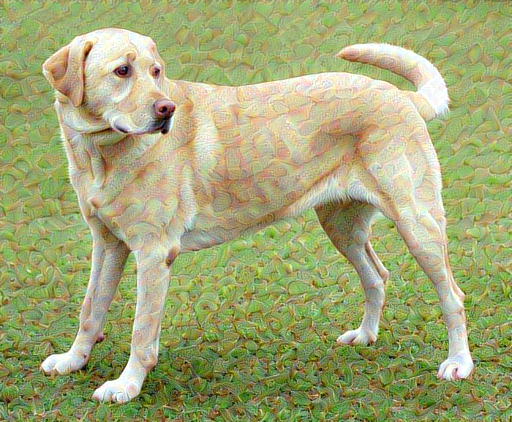

In [33]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)